# Stock Street - Maximizing Portfolio Return using Reinforcement Learning Algorithms

## Libraries and Dependencies

In [ ]:
# !pip uninstall setuptools -y
# !pip install setuptools==65.5.0
# !pip install stable-baselines3[extra]

In [ ]:
# !pip install gym==0.21

In [ ]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
# !pip uninstall -y numpy
# !pip install numpy==1.8

Ignore errors

In [ ]:
#FIRST RESTART RUNTIME IMPORTANT 
# !pip install numpy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Environment

Welcome to StockStreet! - the place where agents come to cry!

<br>
<br>

The building of the environment was an iterative and time consuming process to be able to properly capture the intricacies of trading. This is environment was built from scratch using the base functions provided on Edunao. It proved to be challenging to consider all the scenario that a player could run into while running the environment. We believe this final construction provides some solutions to deal with special cases that the agent could run into. First we will define our environment space:

**Action Space** - These actions can be any **continuous** number [-1,1] a negative action, zero, positive action would indicate sell, hold, buy respectively. This action is multiplied within the environment by the maximum amount of stock set as a parameter indicate the buy or sell order. The action space is a BOX since it would need to simulated for an **n** number of stocks.

**State Space** - The state space consists of the following information:

      1 - Portfolio: The amount of cash and the number of stocks (of each stock) owned by the player.

      2- Market: The latest Close price information available for each stock.

      3 - Trading Signals: 8 Trading Signals are calculated for each of the stocks daily (based on different historical time intervals). These include the Realtive Strength Index (RSI), the Moving Average Convergence/Divergence (MACD), the signal from the MACD, the Price Momentum (MOM), Williams %R (WILL R), Average True Range (ATR), Price Moving Average of the last 30 days (MA_30), the On-Balance Volume (OBV). In Addition to these 8 signals per stock, the ATR of the VIX (a market volatility index) is also considered. Other signals considered for the VIX were the actual quoting of the value of the VIX and the VIX 30 days prior. 

The values of the state space of scaled in order for the agent to be capable to learn from the observations. At environment reset scalars are calculated as a method to attempt to normalize each of the observations. Normalization techniques have not been used as these could cause a data leakage. The scalars calculated at reset only are the used to scaled the observations throughout training. The real values can be obtained from the environment info at each step.

**Reward** - The agent is rewarded based by calculating the amount daily return on the portfolio on each day in absolute terms. This is the most complex part that needed to be thought of to consider the several impact that such a reward could have on the agent (more discussed in the report and conclusion).

<br>

<u> Environment Construction: </u>

Financial Data is extracted using the yfinance API. This API has a popular bug in that financial data of only up to two stocks can be extracted (any higher will output NaN values). This was sufficient for the purposes of our experiments since agents will be tested to trade up to two stock only as this was already a complex task. The environment also extracts financial data from the VIX which is a widely used volatility tracker in the market. For the purposes of this environment, market data is taken using the Close price (yesterday's Close is today's opening price). A default window size of 126 is set for the environment (half a trading year). Therefore the player start 126 days after he initialized start date of training. This is done to ensure that the player has access to sufficient financial data through the environment provided technical trading signals. 

The environement resets by initializing the player's portfolio. This consists randomizing the starting number of stocks in the portfolio to an amount <= 10% of the initial starting cash. The value of this stock is subtracted form the starting cash (minus the fees associated with the order). The trade signals are calculated for the provided period and all observations are scaled by the technique described above. The environment then returns the observation.

At every time step, the player steps one trading day later. Based on the action taken using the information provided at reset, an action of stocks are bought/sold is taken and the reward is calculated using the latest (and previously unrevealed) prices on the entire portfolio (cash plus stock value). New observations are then generated at that specific day. There are two conditions that the environment checks that could overrdide the player's action:

1- If a player attempts to make a sell action but has no stock left in the portfolio, the sell action is overwritten to 0.

2 - If a player attempts to make a buy action when the cash left in the portfolio is less than 5%, the action is overwritten to 0. Furthermore, the reward is overwritten to get zero to heavily penalize the player for not having sufficient cash in their porfolio. In a previous iteration of this construction, the environment ends once the cash falls below this amount to simplify the problem. However, it was found that this causes the agent to not learn to keep a stable amount of cash in their portfolio when playing. Therefore, this is the current best solution the team proposes however, for future work, a better and mroe complex solution can be considered.

Each step into the environemnt returns the observations described int he state, space, the player's reward at the time step, whether the environment is done, and additional info from the environment (the unscaled version of the observations in a more presentable and clear manner).

<br>
<br>
<u> Trade Signals: </u>

The trading signals listed above were found through *Machine Learning for Algorithmic Trading (Jansen, 2020).* This allows us to create signals for the agent using free available information since there are other better methodsbut require access to paid information (small discussion in report). This environment does not leverage all the recommendations provided in this book and so we can that these agents in practice require much more information to create an extremely powerful agent (this also requires much more computer processign resources). However, this environemnt is sufficient to create a demonstration and training agent capable of making investment decisions. For example a commonly signal is trading  Below are the definitions of the technical indicators used:
<br>
<br>
<font size="2">
\begin{align}
        \text{RSI}  = 100 - \frac{100}{1 + \frac{AvgPrice_{Up}}{AvgPrice_{dwn}}} \text{over a 14 day period}
    \end{align}
This index measures how overbought or sold a stock is.
<br>
<br>
\begin{align}
\text{MACD} = EMA(12) - EMA(26)
\end{align}
EMA is the Exponential Moving Average. This reflects the difference in the short term and log term moving average of the price (this case between a 12-day and 26-day period).
<br>
<br>
\begin{align}
\text{MACD_Signal} = EMA(9)
\end{align}
Serves as the signal line of the MACD.
<br>
<br>
\begin{align}
\text{MOM} = \frac{P_{Period}}{P_{Period - 1}} - 1
\end{align}
Computes the total returns over a given number of days. Whilst is is common to calculate this on 12 month period, in this environment it is adapted over a 60 day period since the window size is half a trading year.
<br>
<br>
\begin{align}
\text{Williams %R} = \frac{P_{Period}^{High} - P_{Period}^{Curr Close}}{P_{Period}^{High} - P_{Period}^{Low}} 
\end{align}
Measures how overbought/sold levels and attempts to identify entry and exit points. This is done over a 14-day period.
<br>
<br>
\begin{align}
\text{ATR} = MAX(P_{Period}^{High} - P_{Period}^{High}, P_{Period}^{High} - P_{Period}^{Close}, P_{Period}^{Low} - P_{Period}^{Close})
\end{align}
Measures volatility in the stock
<br>
<br>
\begin{align}
\text{MA_30} = MA(30)
30 Day- Price Moving Average
<br>
<br>
Finally, OBV observes changes in the volume of stock traded based on the difference between the current and previous price. It adds/subtracts volume to/from the current OBV depending if the current price is higher/lower from the previous price.
<br>
<br>
</font>

<u> Environment Rendering: </u>

If dynamic rendering is on, the environment will be rendered every 30 days to show  each stock's market price within the specified window size. Also rendered, is the buy and sell actions made by the player. This rendering could dramatically slow down runtime. A rendering can also be called by using the render function that produces a similar plot from the start of trade till the current day and displys a 30 moving average for of the orders made by the player. This is only generated if called from the environment. A demonstration of the environment as well as the rendering is shown below.



<br>
<u> Mentions: </u>

*Some inspiration for financial ideas only for the environment was the FinRL repository.*

##Testing the Environment

Below we demonstrate the rendering of the environment In the below example actions are randomly sampled from the environment. 

For the below demonstration, we shall observe the simulation of trading SPDR S&P 500 (a derivative that tracks the S&P 500 Index) and the stock of McDonalds.

In [ ]:
from env.version_0_build import StockStreet

In [ ]:
stocks = ["SPY", "MCD"] # list of stocks to be traded
start_date = "2009-12-31" #start date of the environment
end_date = "2020-01-01" #end date of the environment
start_cash =  1e6 #the starting capital of the player
trade_fee = 1e-2 #For each buy/sell order, the player shall be charged a comission on the total value of the trade
max_order = 100 #The max stock that can be traded in the environment. The action shall be multiplied to this amount to determine the stock traded by the player
scalar = 1e-4 #The amount by which the stock price shall be scaled in the state space. All other values are scaled as a proportion of this.
window = 252 //2 #The trading window is the number of days  of historical data that the player has at any given day. In this case, it is half a trading year
render = True #Renders set window every 30 days
add_rew_scale = 1e-3 #adds additional scaling to the reward of the agent

env = StockStreet(stocks, init_date = start_date, end_date = end_date, init_capital = start_cash, 
                  buy_fee = trade_fee, sell_fee = trade_fee, max_stock_trade_qty = max_order, 
                  scale_factor = scalar, window_size = window, dyn_render = render, 
                  reward_add_scale = add_rew_scale)

The reset outputs the first rendering. **The start date of playing would at the end of the first window** so that the agent has access to data from the first trading window. At this point the agent has still not taken any action and so we do not yet observe any buy or sell orders. The state observation has 22 values consisting of:
  
    1-  The cash the player owns (1x)
    2- The quantity of stock held of SPY and MCD respectively (2x)
    3 - The last closing price of SPY and MCD respectively (2x)
    4- The trading signals associated with SPY and MCD respective plus the signal for the VIX (17x - 8 for each plus 1 from VIX)


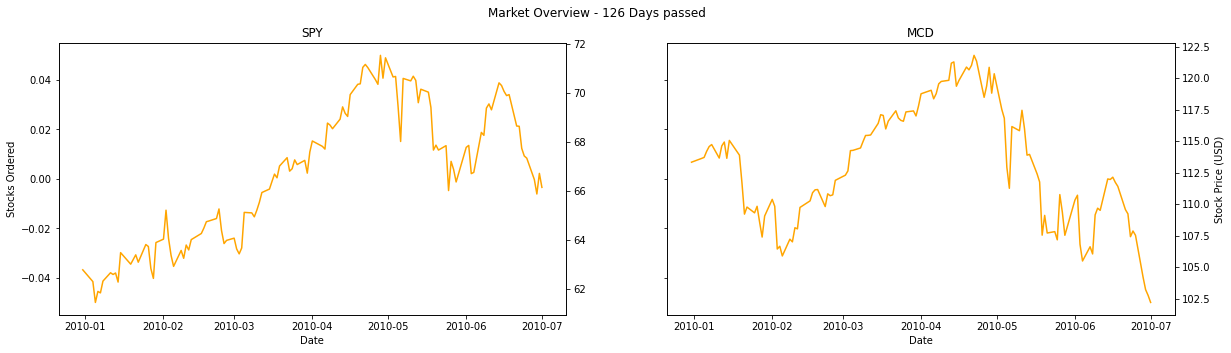


 Observation: 
 [ 0.00891287  0.00603     0.00656     0.006614    0.01022     0.0040135
  0.00308926 -0.00512745 -0.00181776 -0.00322764 -0.00601948 -0.00989998
 -0.00156    -0.00734345 -0.00864954  0.00114854  0.00225907  0.00680237
  0.00108414  0.00216058 -0.0018156   0.00366985]


In [6]:
starting_state =  env.reset()

print(f"\n Observation: \n {starting_state}")

Let us simulate the evironment over one year. WE can see the buy (in green) and sell (in red) orders made by the random action taking agent. These orders are capped between [-100,100] since this was the inputed maximum stock order per day. The left y axis corresponds to the number of stocks bought/sold and the right y scis corresponds to the stock price.

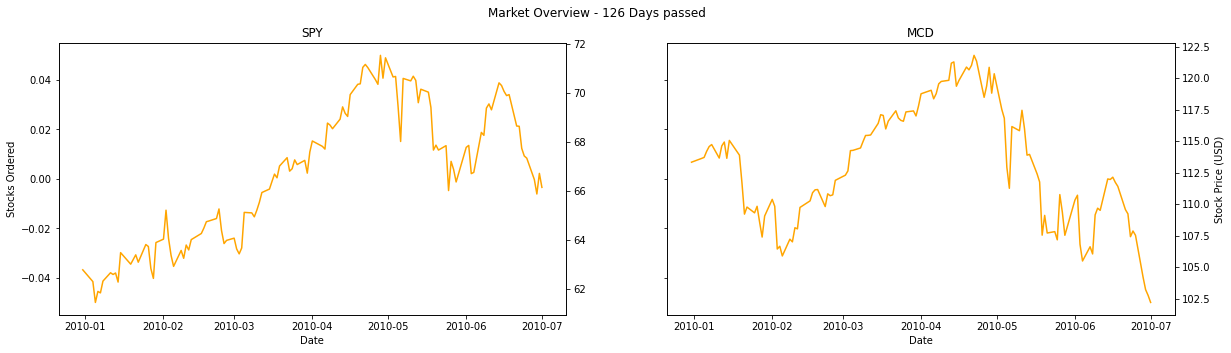

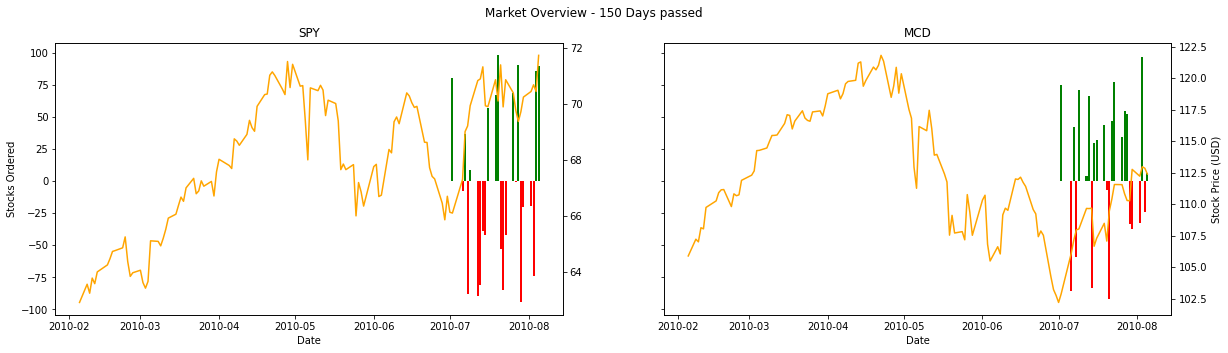

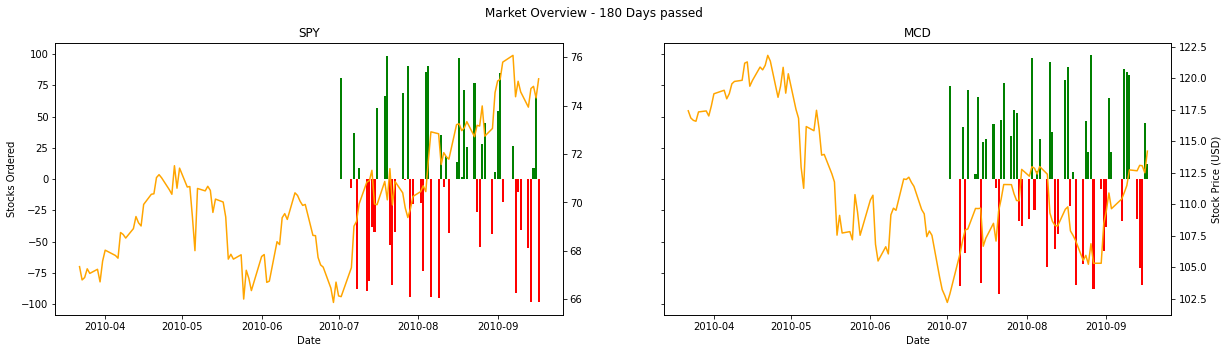

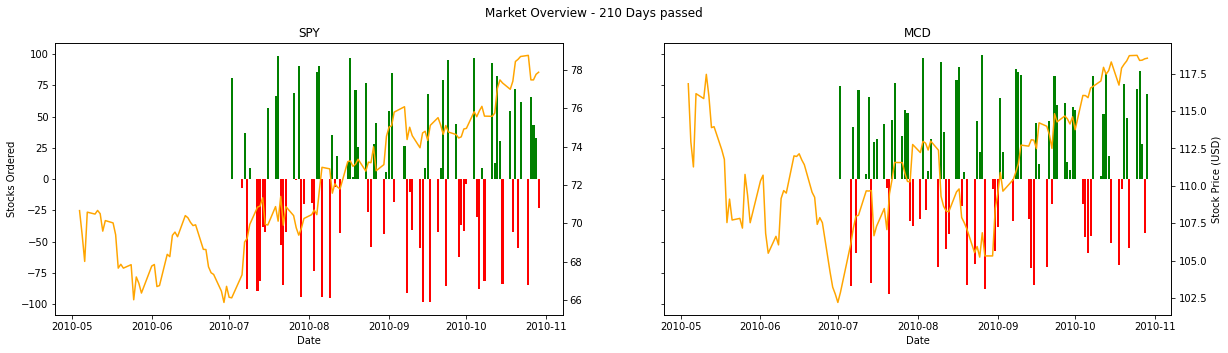

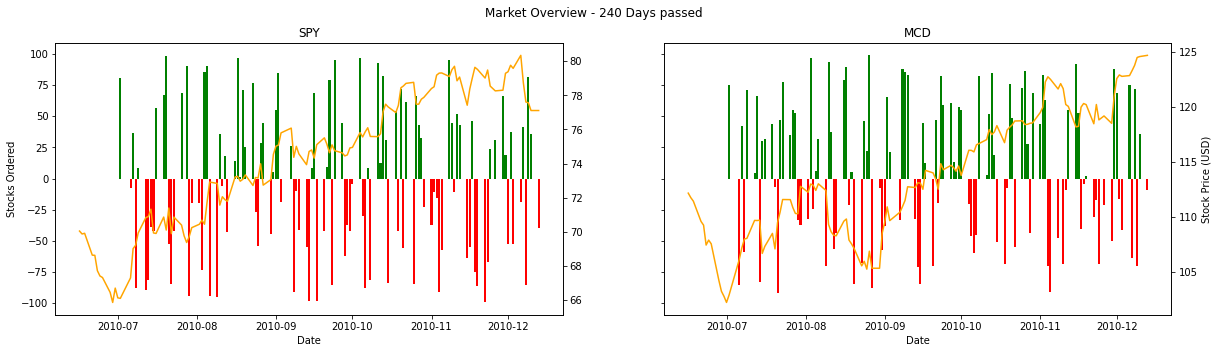

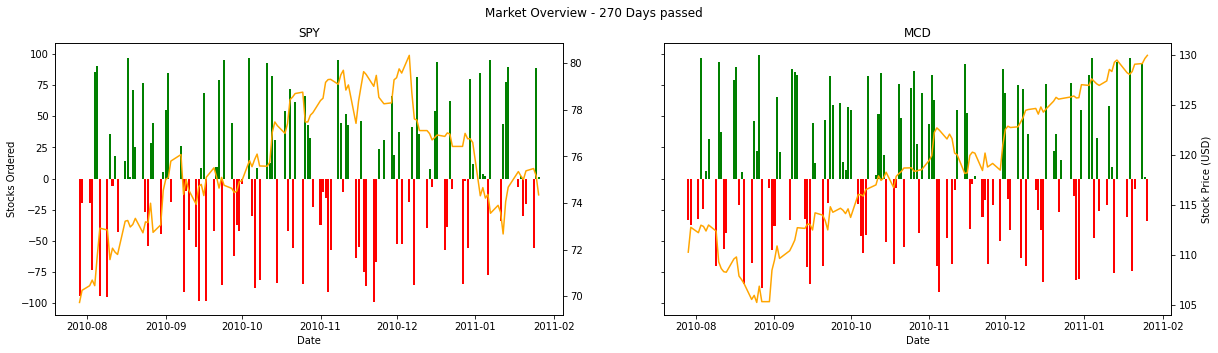

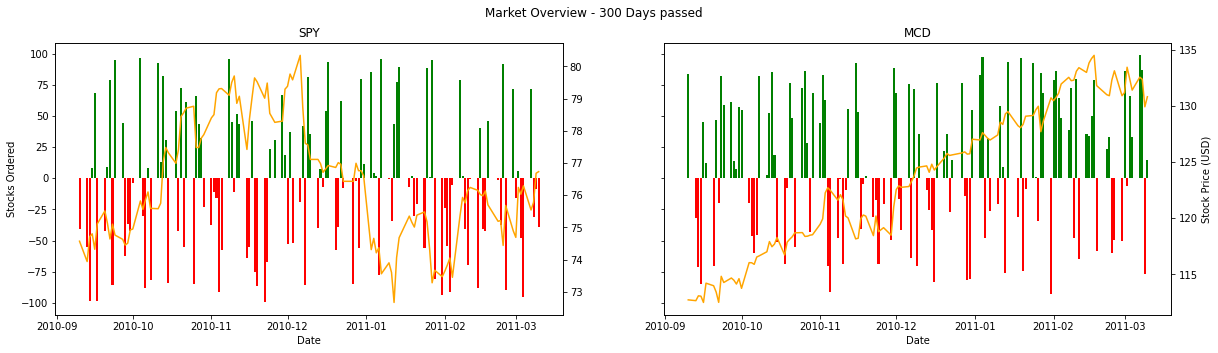

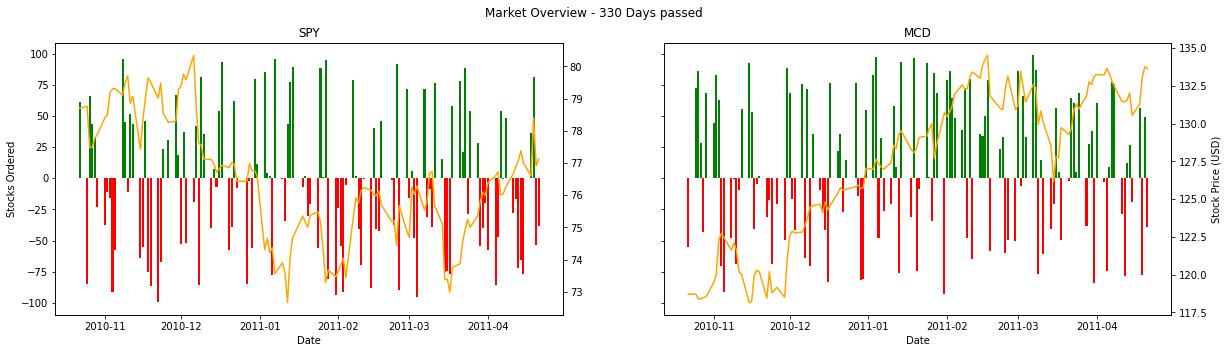

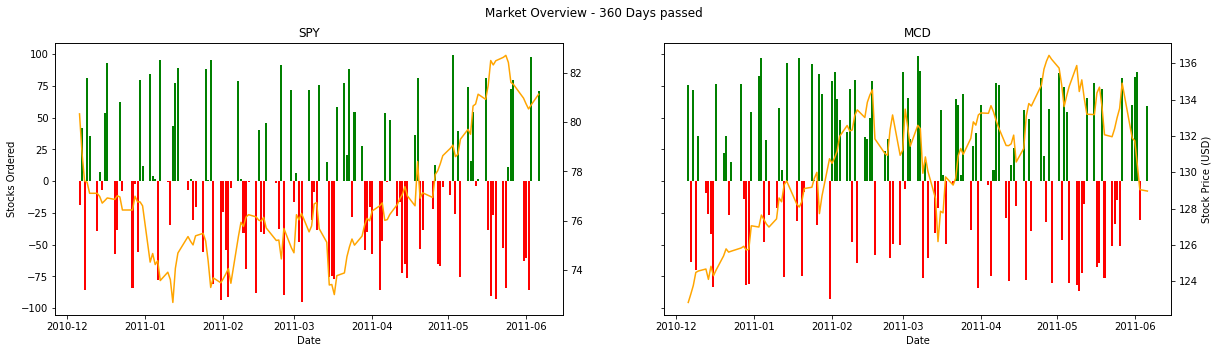

In [7]:
env.reset()
t = 0

while t < 252:
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action) 
  t +=1 

# Single Stock Training

We begin with a simple trading environment by training our agents on only on SPDR. The training period shall be from 2010 - 2016. The agents shall then also be evaluated on a testing period from 2017 - 2019. These dates were selected to avoid exterme events such as the 2008 Financial Crisis and Covid. Due to the nature of the environment, we require agents capable of training in a continuous setting with an inifinite number of states. Furthermore, since the stock market tends to not assume any underlying distribution, it is difficult to tackle the problem with an on-policy agent. Hence, we shall rely on off-policy agents that are also modified to handle the specific continuous output from the StockStreet environment. The stable_baseline3 library provides several sources of agents that can be leveraged to this regard. We have specifically chosen the Advantage Actor-Critic (A2C) and Proximal Policy Optimization (PPO) for this excercise.

In [11]:
stock_list = ["SPY"]
start_train = "2009-12-31"
end_train = "2016-12-31"
start_test = "2016-08-28"
end_test = "2020-01-01"
start_cash = 1e6
trade_fee = 1e-2
max_order = 100
scaling = 1e-4
window = 252 // 2
render = False
scaled_reward = 1
train = True #to inform the environment that an agent is being trained

env = StockStreet(stock_list, init_date = start_train, end_date = end_train, init_capital = start_cash, buy_fee = trade_fee, 
                  sell_fee = trade_fee, max_stock_trade_qty = max_order, scale_factor = scaling, window_size = 252 // 2,
             dyn_render = False,full_render = True, reward_add_scale = scaled_reward, train_agent = train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Parameter Sweep - Based on the Old Environment (See exaplanation in Trading Evaluation Section)

We will first conduct a parameter sweep to find the optimal hyperparameters for use. As this environment takes a long time to run in its current version, tuning shall occur only on three variables gamma, learning rate, and timesteps. The gamma is intentionally kept relatively high since the agent should not heavily discount the impact of future rewards in the context of trading. Best models are decided based on  an evaluation of the policy of the agent under each set of parameters. The policy is evaluated over a run of 10 episodes and the average reward per episode (scaled) is taken. The parameters are chosen for the agent with a policy that yields the highest average reward per episode.

In [ ]:
from stable_baselines3 import A2C, PPO #library with deep learning agents

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy # allows the evaluation of agent policies

### Advantage Actor-Critic (A2C) Tuning

In [ ]:
parameters = {"gamma": [0.9, 0.97, 0.99],
              "learning_rate": [0.0003, 0.03],
              "time_steps" : [10000, 30000]}
iter = 0
best_reward = 0
cumul_rewards = {}
for gamma in parameters["gamma"]:
  for lr in parameters["learning_rate"]:
    for t in parameters["time_steps"]:
      iter+=1
      print(iter)
      model = A2C("MlpPolicy", env, verbose=0, device = "cuda", gamma = gamma, learning_rate = lr)
      model.learn(total_timesteps= t)
      mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
      
      if mean_reward > best_reward:
        model.save("best_model_a2c")
        best_reward = mean_reward
        print("Best Reward:",best_reward)
        print("Best Parameters:",gamma, lr, t)

1
Best Reward: 3.3277879999999995
Best Parameters: 0.9 0.0003 10000
2
3
Best Reward: 4.848217
Best Parameters: 0.9 0.03 10000
4
5
Best Reward: 6.007925999999999
Best Parameters: 0.97 0.0003 10000
6
7
8
9
10
11
12


In [ ]:
best_model_a2c = model.load("best_model_a2c.zip")

### Proximal Policy Optimization (PPO) Tuning

In [ ]:
parameters = {"gamma": [0.97, 0.99],
              "learning_rate": [0.0003],
              "time_steps" : [10000, 30000]}
iter = 0
best_reward = 0
cumul_rewards = {}
for gamma in parameters["gamma"]:
  for lr in parameters["learning_rate"]:
    for t in parameters["time_steps"]:
      iter+=1
      print(iter)
      model = PPO("MlpPolicy", env, verbose=0, device = "cuda", gamma = gamma, learning_rate = lr)
      model.learn(total_timesteps= t)
      mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
      
      if mean_reward > best_reward:
        model.save("best_model_ppo")
        best_reward = mean_reward
        print("Best Reward:",best_reward)
        print("Best Parameters:",gamma, lr, t)

1
Best Reward: 8.242774
Best Parameters: 0.97 0.0003 10000
2
3
Best Reward: 26.415557999999997
Best Parameters: 0.99 0.0003 10000
4


In [ ]:
parameters = {"gamma": [0.9, 0.97, 0.99],
              "learning_rate": [0.0003, 0.03],
              "time_steps" : [10000, 30000, 100000]}
iter = 0
best_reward = 0
cumul_rewards = {}
for gamma in parameters["gamma"]:
  for lr in parameters["learning_rate"]:
    for t in parameters["time_steps"]:
      iter+=1
      print(iter)
      model = PPO("MlpPolicy", env, verbose=0, device = "cuda", gamma = gamma, learning_rate = lr)
      model.learn(total_timesteps= t)
      mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
      
      if mean_reward > best_reward:
        model.save("best_model_ppo")
        best_reward = mean_reward
        print("Best Reward:",best_reward)
        print("Best Parameters:",gamma, lr, t)

1
Best Reward: 0.801633
Best Parameters: 0.9 0.0003 10000
2
3
Best Reward: 7.789713000000001
Best Parameters: 0.9 0.0003 100000
4
5
Best Reward: 9.709365000000002
Best Parameters: 0.9 0.03 30000
6
7
Best Reward: 12.080169999999999
Best Parameters: 0.97 0.0003 10000
8
Best Reward: 40.41580799999999
Best Parameters: 0.97 0.0003 30000
9
10
11
12
13
14
Best Reward: 54.574837
Best Parameters: 0.99 0.0003 30000
15
Best Reward: 75.92631000000002
Best Parameters: 0.99 0.0003 100000
16
17
18


## Final Model Training

Best Trained Models can already be loaded in the Trading Evaluation Section.

### A2C

In [ ]:
best_model_a2c = A2C("MlpPolicy", env, verbose=1, device = "cuda",learning_rate=0.0003, gamma = 0.97,
            n_steps = 5, ent_coef = 0.005)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
best_model_a2c.learn(10000, progress_bar = False)

------------------------------------
| time/                 |          |
|    fps                | 227      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0.23     |
|    learning_rate      | 0.0003   |
|    n_updates          | 99       |
|    policy_loss        | -0.0161  |
|    std                | 1        |
|    value_loss         | 0.000179 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 204      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0.0637   |
|    learning_rate      | 0.0003   |
|    n_updates          | 199      |
|    policy_loss        | -0.337   |
|

In [ ]:
best_model_a2c.save("best_model_a2c_single")

### PPO

In [59]:
best_model_ppo = PPO("MlpPolicy", env, verbose=1, device = "cuda", gamma = 0.97, learning_rate = 0.0003)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
best_model_ppo.learn(total_timesteps=30000, progress_bar = False)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.64e+03 |
|    ep_rew_mean     | 45.3     |
| time/              |          |
|    fps             | 281      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.64e+03   |
|    ep_rew_mean          | 30.5       |
| time/                   |            |
|    fps                  | 245        |
|    iterations           | 2          |
|    time_elapsed         | 16         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00137451 |
|    clip_fraction        | 0.000146   |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | -0.0131    |
|    learning_rate        | 0.0003     |
|   

In [17]:
best_model_ppo.save("best_model_ppo_single")

## Trading Evaluation

In order to evaluate the agents, they shall  not only be compared with one another, but also with:
  
  1- Long Only Player: A player that buys that maximum number of stocks until cash runs low and holds this position until the day of the environment simulation.

  2- Clueless Player: An agent that takes random actions.

<br>

For the moment is is difficult to evaluate performance with other papers due to the signfiicant difference, in indices, trading periods, methods, observation and action space, environment, etc.


The players shall be evaluated:

  1 - Cumulative Returns

  2 - 30 Day Average Portfolio Returns

  3 - Monthly Sharpe Portfolio Sharpe Ratio

The final metric can give us a better idea of the agent's performance relative to Long Only ad it takes into account, the variance in the portfolios returns.

<br>

Due to the continous nature of the environment, it is difficult to visualize policy and value functions. However, this could be something to consider for future work to consider some approximative techniques to compare the policies and value functions of the agents.



We have ran tests using our old and new environment. In the Old Environment, agents were trained in a manner such that if their cash dropped below <= 5% of the initial capital, the environment ends. Hence, the rewards of an agents stop once they buy too much stock. This is then compared to our New Environment that does not end when cash drops below 5% of the initial amount. Instead, buy actions will be overwritten to zero and the agent's reward is overwritten to zero to encourage the agent to sell when in such a situation.

In [ ]:
from simulation import trade #function to simulate trading with a player

In [20]:
model = A2C("MlpPolicy", env)
best_model_a2c = model.load("best_model_a2c_single.zip")
model = PPO("MlpPolicy", env)
best_model_ppo = model.load("best_model_ppo_single.zip")

#### <u> **Training Period:** </u>
<br>
<br>
Below are plots of the the agents compared to Long Only and the Clueless player. The plots below show the cumulative reward of each player, the 30 day average of the rewards, the actions taken by each player, and the environment adjusted actions (override actions if the player, has no stock <= 5% cash).

**Over 1 Episode**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


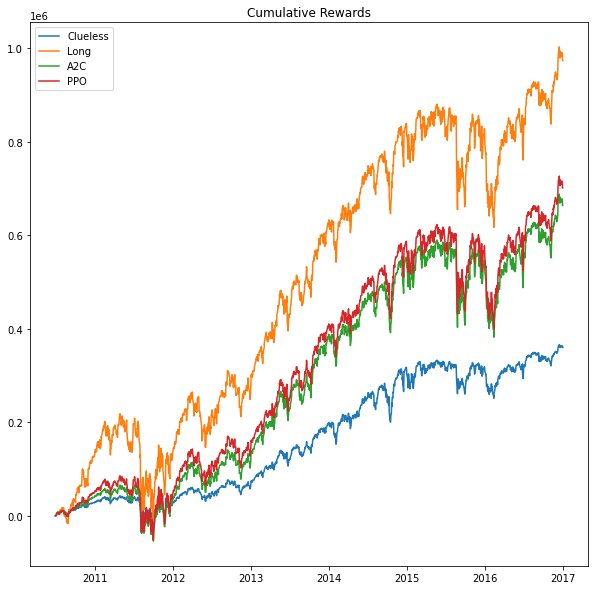

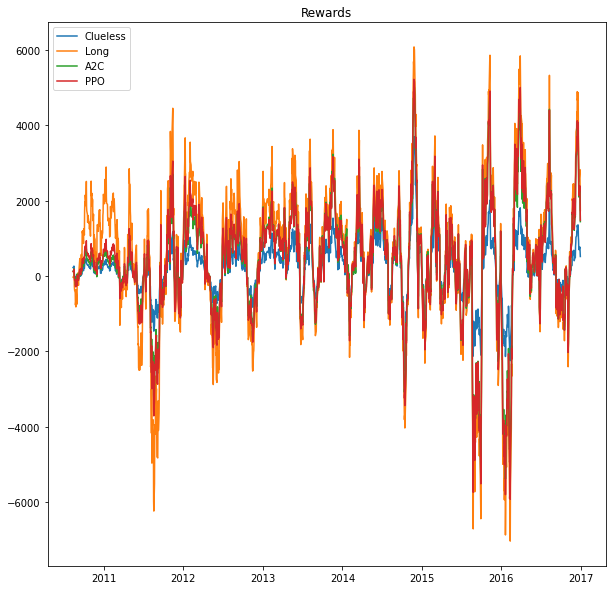

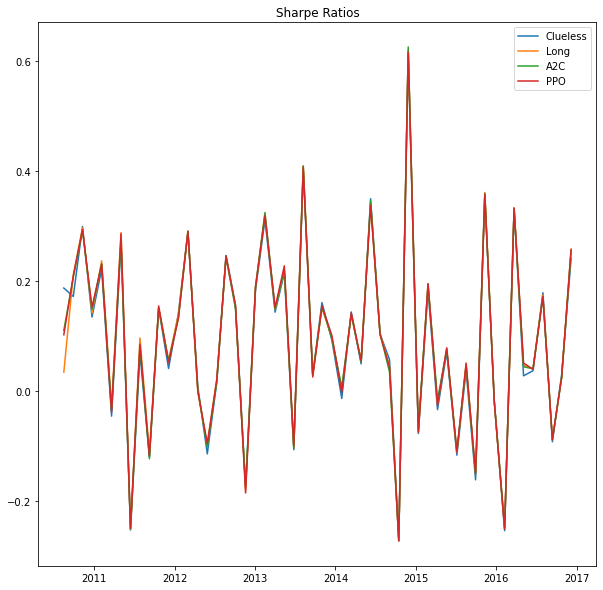

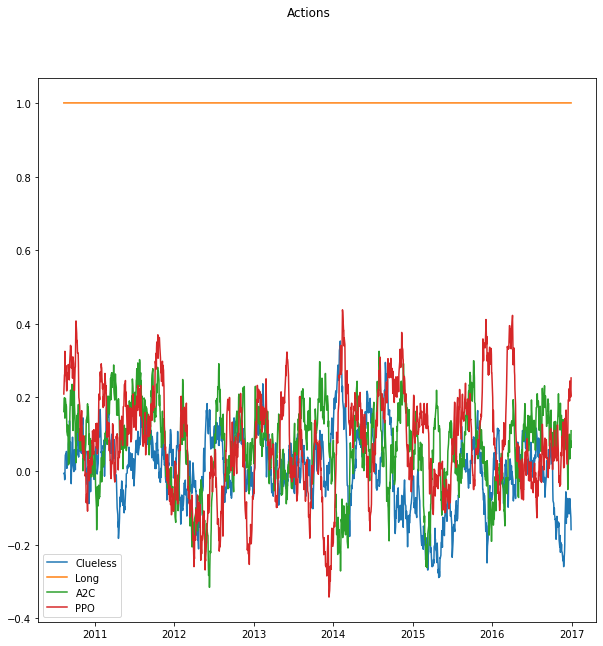

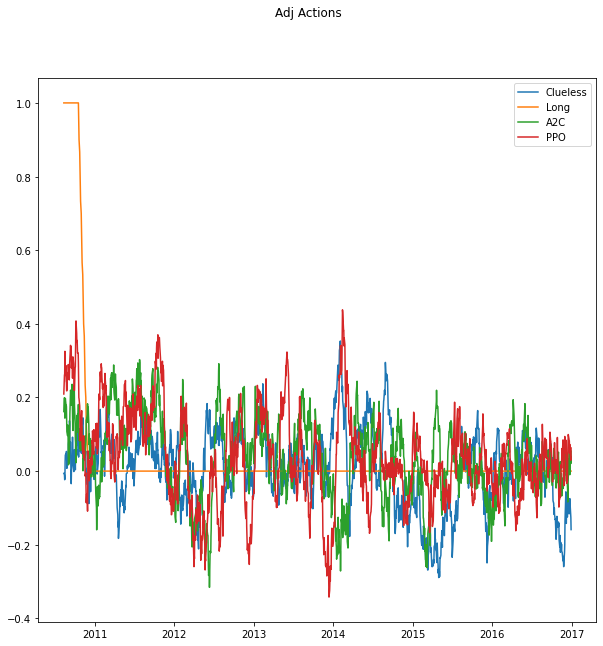

In [ ]:
player_rewards = []
player_sharpes = []
player_actions = []
player_adj_actions = []
players = ["Clueless", "Long", "A2C", "PPO"]
player_models = {"Clueless": None, "Long": None, "A2C": best_model_a2c, "PPO": best_model_ppo}
for player in players:

  rewards, sharpe_ratios, actions, adj_actions, dates, _ = trade(player, player_models[player], stock_list, 
                                                                     start_cash = start_cash, start_date = start_train, 
                                                                     end_date = end_train, trade_fee = trade_fee, 
      max_stock_order = max_order, scaling_factor = scaling, window = window, render = render, 
      rolling_action = 30, reward_scaling = scaled_reward, plot = False)

    
  player_rewards.append(rewards)
  player_sharpes.append(sharpe_ratios)
  player_actions.append(actions)
  player_adj_actions.append(adj_actions)

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window: window + len(rewards)], np.cumsum([player_rewards[k]]) / scaling / scaled_reward, 
           label = player)
plt.legend()
plt.title("Cumulative Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window: window + len(rewards)], 
           pd.DataFrame(np.array([player_rewards[k]]).reshape(len(player_rewards[k]),1)).rolling(30).mean() / scaling / scaled_reward, 
           label = player)
plt.legend()
plt.title("Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window + 30 : len(rewards) + window : 30], player_sharpes[k], label = player)
plt.legend()
plt.title("Sharpe Ratios")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_actions[k])[i].rolling(30).mean(), 
              label = player)
  axes.legend()       
plt.suptitle("Actions")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_adj_actions[k][window:])[i].rolling(30).mean(), label = player)
  axes.legend()       
plt.suptitle("Adj Actions")
plt.show()
print("")

**Averaged over 10 episodes**

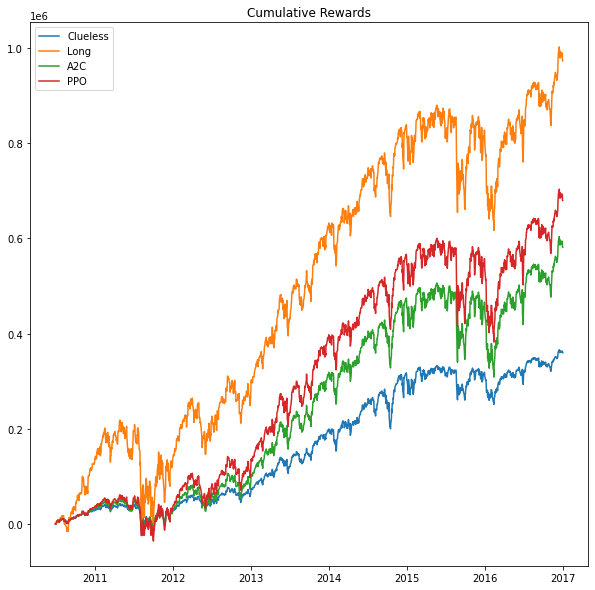

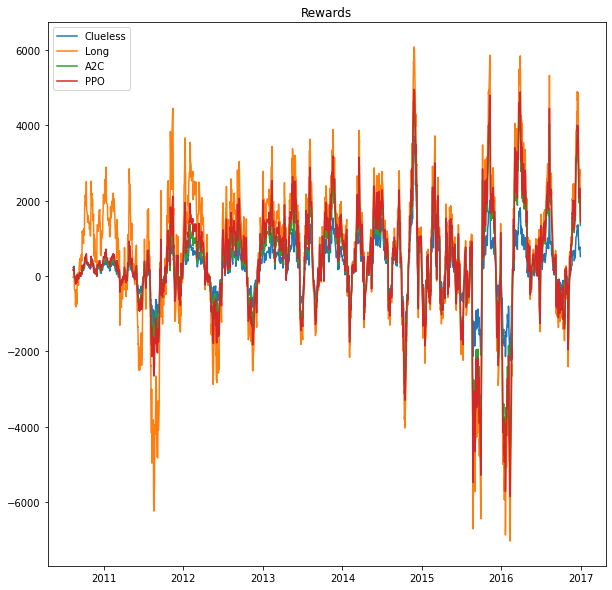

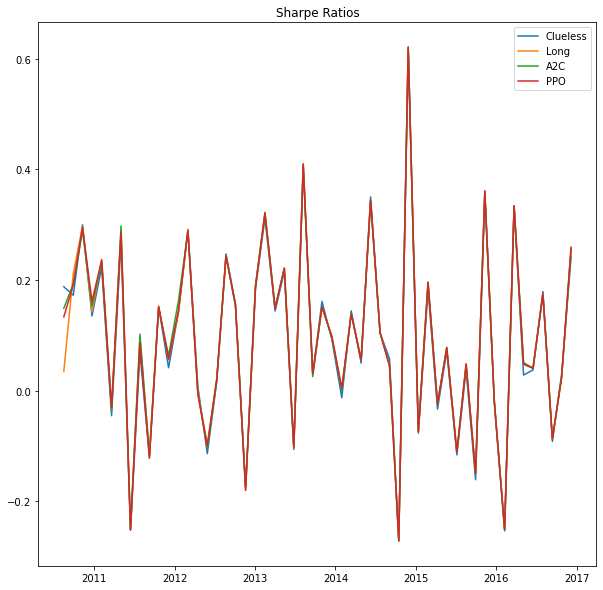

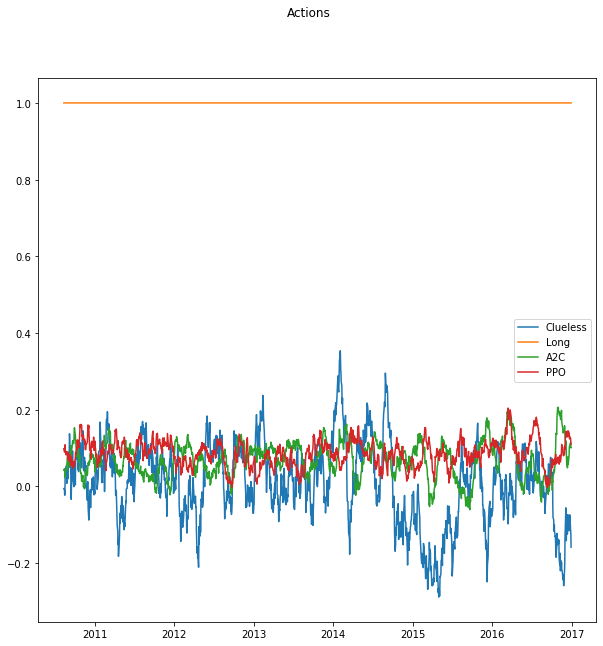

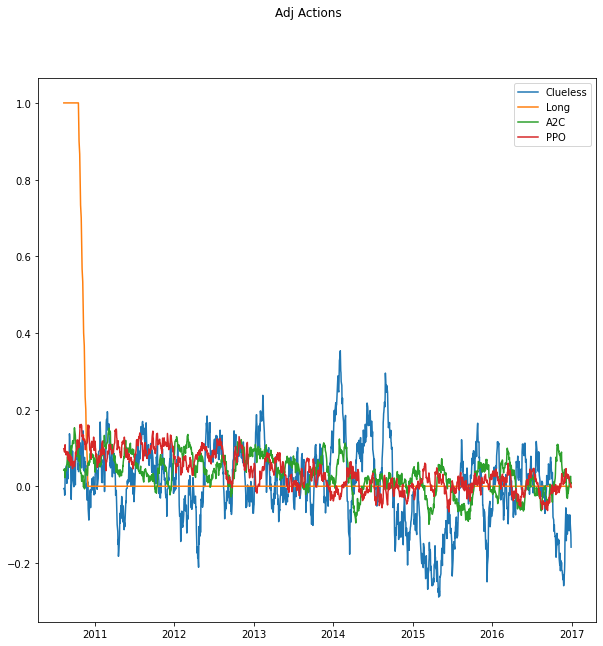

In [ ]:
player_rewards = []
player_sharpes = []
player_actions = []
player_adj_actions = []

player_rewards_dict = {}
player_sharpes_dict = {}
player_actions_dict = {}
player_adj_actions_dict = {}
episode_runs = 10
for i in range(episode_runs):
  players = ["Clueless", "Long", "A2C", "PPO"]
  player_models = {"Clueless": None, "Long": None, "A2C": best_model_a2c, "PPO": best_model_ppo}
  for player in players:

    rewards, sharpe_ratios, actions, adj_actions, dates, _ = trade(player, player_models[player], stock_list, 
                                                                      start_cash = start_cash, start_date = start_train, 
                                                                      end_date = end_train, trade_fee = trade_fee, 
        max_stock_order = max_order, scaling_factor = scaling, window = window, render = render, 
        rolling_action = 30, reward_scaling = scaled_reward, plot = False)
    
    adj_actions = [a for b in adj_actions for a in b]


    if i < 1:
      player_rewards_dict[player] = rewards
      player_sharpes_dict[player] = sharpe_ratios
      player_actions_dict[player] = actions
      player_adj_actions_dict[player] = adj_actions
    elif i >= episode_runs - 1:
      player_rewards_dict[player] = [(x+y)/episode_runs for x,y in zip(player_rewards_dict[player], rewards)]
      player_sharpes_dict[player] = [(x+y)/episode_runs for x,y in zip(player_sharpes_dict[player], sharpe_ratios)]
      player_actions_dict[player] = [(x+y)/episode_runs for x,y in zip(player_actions_dict[player], actions)]
      player_adj_actions_dict[player] = [(x+y)/episode_runs for x,y in zip(player_adj_actions_dict[player], adj_actions)]
    else:
      player_rewards_dict[player] = [x+y for x,y in zip(player_rewards_dict[player], rewards)]
      player_sharpes_dict[player] = [x+y for x,y in zip(player_sharpes_dict[player], sharpe_ratios)]
      player_actions_dict[player] = [x+y for x,y in zip(player_actions_dict[player], actions)]
      player_adj_actions_dict[player] = [x+y for x,y in zip(player_adj_actions_dict[player], adj_actions)]
      
for player in players:

  player_rewards.append(player_rewards_dict[player])
  player_sharpes.append( player_sharpes_dict[player])
  player_actions.append(player_actions_dict[player])
  player_adj_actions.append(player_adj_actions_dict[player])


plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window: window + len(rewards)], np.cumsum([player_rewards[k]]) / scaling / scaled_reward, 
           label = player)
plt.legend()
plt.title("Cumulative Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window: window + len(rewards)], 
           pd.DataFrame(np.array([player_rewards[k]]).reshape(len(player_rewards[k]),1)).rolling(30).mean() / scaling / scaled_reward, 
           label = player)
plt.legend()
plt.title("Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window + 30 : len(rewards) + window : 30], player_sharpes[k], label = player)
plt.legend()
plt.title("Sharpe Ratios")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_actions[k])[i].rolling(30).mean(), 
              label = player)
  axes.legend()       
plt.suptitle("Actions")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_adj_actions[k][window:])[i].rolling(30).mean(), label = player)
  axes.legend()       
plt.suptitle("Adj Actions")
plt.show()
print("")

In [ ]:
pd.DataFrame(player_sharpes_dict).to_csv("Single_stock_Sharpes_10_ep.csv")
pd.DataFrame(player_rewards_dict).to_csv("Single_stock_Rewards_10_ep.csv")

Observation: 

In this environment the PPO and A2C agents both outperform the Clueless Player consistently over 10 episodes. The PPO Agent also outperforms the A2C agent. We can see that it is difficult to interpret the results of the actions when averaged over the 10 episodes as actions are inconsistent on a daily level. Hence, by looking at the 1 episode plot of actions. It can be inferred that both agents tend to take similar actions prior to 2014 but start to diverge after this point. This is due to the two shocks that can be observe in mid 2015 to mid 2016 and it seems the agents respond to these shicks differently. The PPO agent seems to learn to adjust its buy sell/positions more actively than the PPO to this shock whereas the A2C only decide to take a buying approach that is more conservative until after thick has past. It is not possible to extract any useful information from the Sharpe Ratio other than to say both agents have closely followed the monthly sharpe as that of the Long Only position. **In this Single Stock Trading setting it is difficult for the agent to outperform the Long Only position using this metric.**

#### <u> **Testing Period:** </u>
<br>
<br>

**Over 1 Episode**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


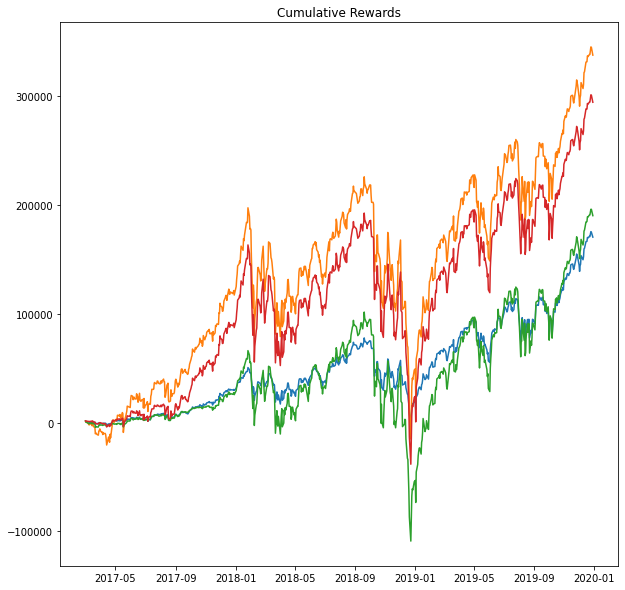

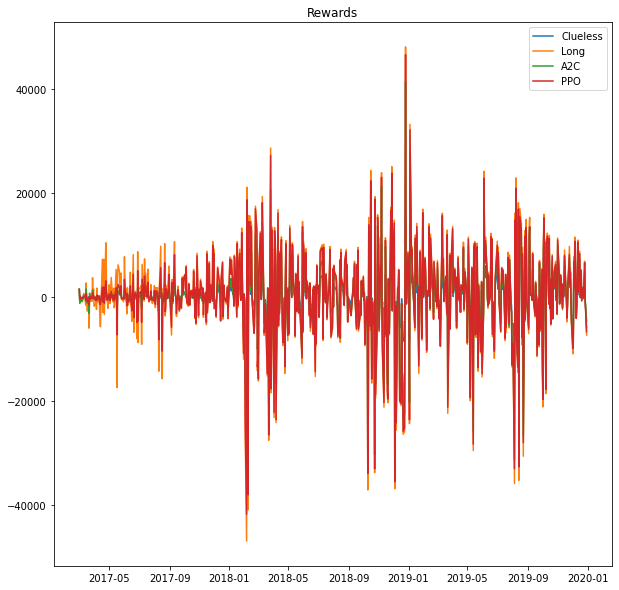

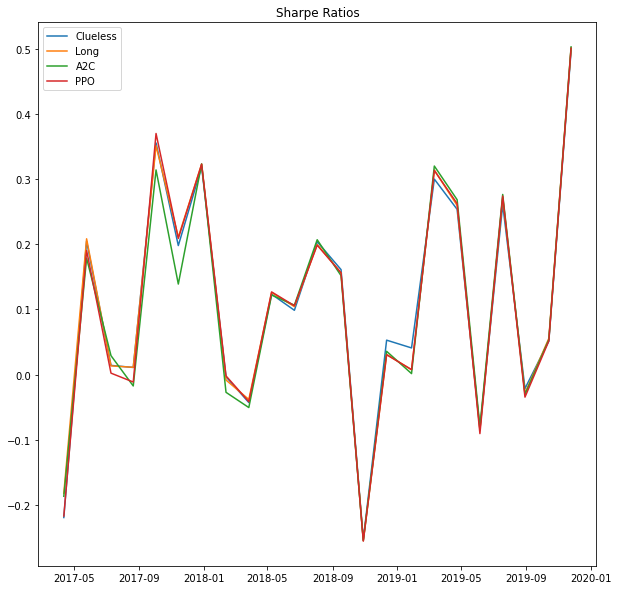

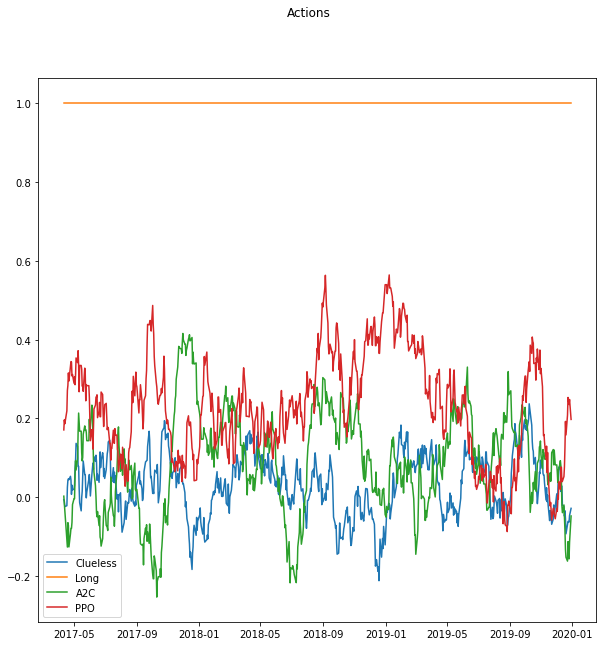

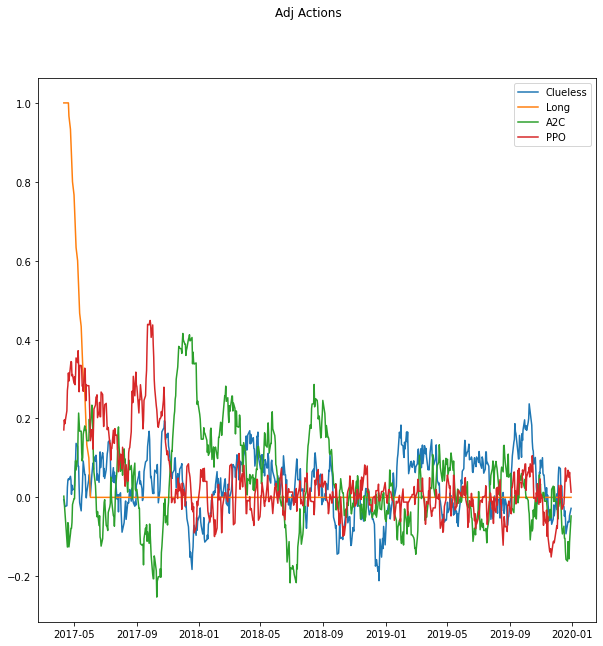

In [ ]:
player_rewards = []
player_sharpes = []
player_actions = []
player_adj_actions = []
players = ["Clueless", "Long","A2C", "PPO"]
player_models = {"Clueless": None, "Long": None, "A2C": best_model_a2c, "PPO": best_model_ppo}
for player in players:
  
  rewards,sharpe_ratios, actions, adj_actions, dates, dones = trade(player,player_models[player], stock_list , 
      start_cash = start_cash, start_date = start_test, end_date = end_test, trade_fee = trade_fee, 
      max_stock_order = max_order, scaling_factor = scaling, window = window, render = render, 
      rolling_action = 30, reward_scaling = scaled_reward, plot = False)

    
  player_rewards.append(rewards)
  player_sharpes.append(sharpe_ratios)
  player_actions.append(actions)
  player_adj_actions.append(adj_actions)


plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window: window + len(rewards)], np.cumsum([player_rewards[k]]) / scaling / scaled_reward, 
           label = player)

plt.title("Cumulative Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):

  plt.plot(dates[window: window + len(rewards)], 
           np.array([player_rewards[k]]).reshape(len(player_rewards[k]),) / scaling / scaled_reward, label = player)
plt.legend()
plt.title("Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window + 30 : len(rewards) + window : 30], player_sharpes[k], label = player)
plt.legend()
plt.title("Sharpe Ratios")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_actions[k])[i].rolling(30).mean(), 
              label = player)
  axes.legend()       
plt.suptitle("Actions")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_adj_actions[k][window:])[i].rolling(30).mean(), label = player)
  axes.legend()       
plt.suptitle("Adj Actions")
plt.show()
print("")

**Over 10 Episodes**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

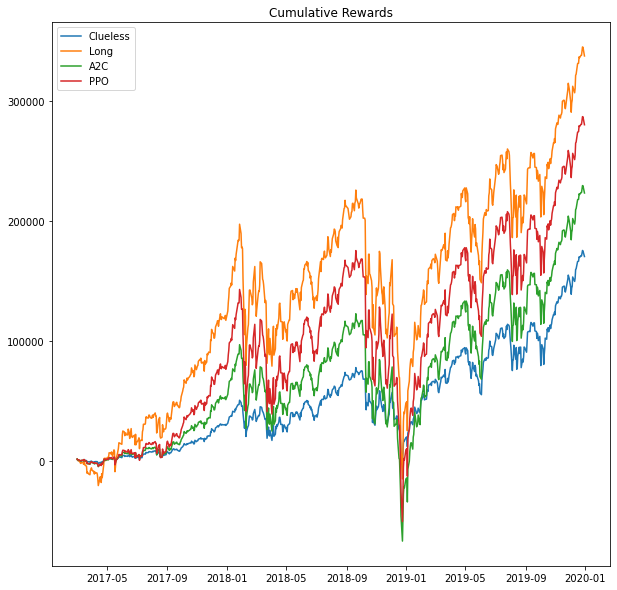

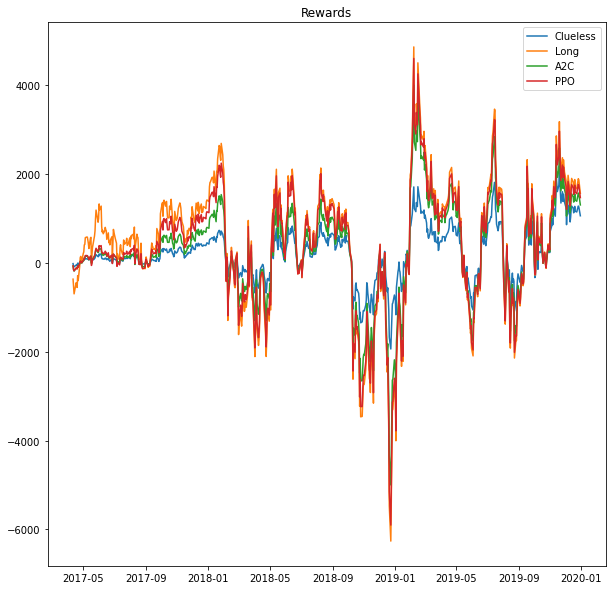

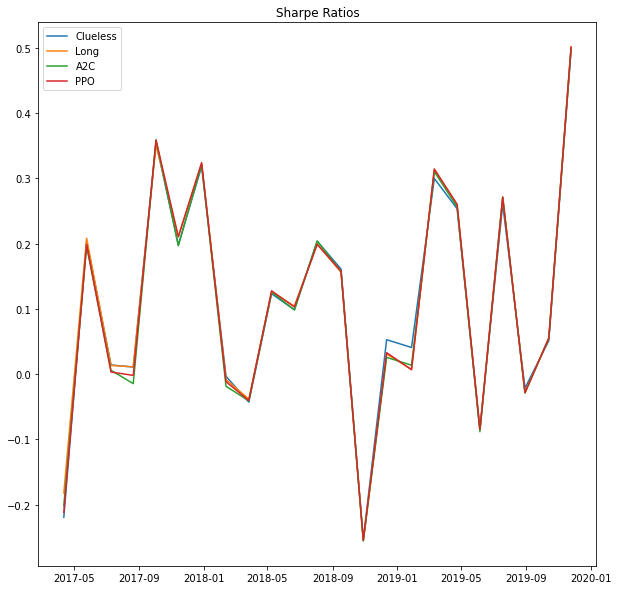

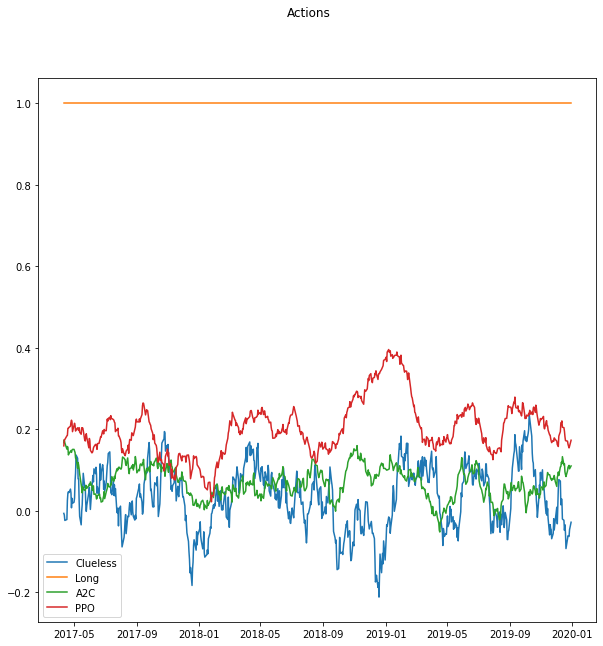

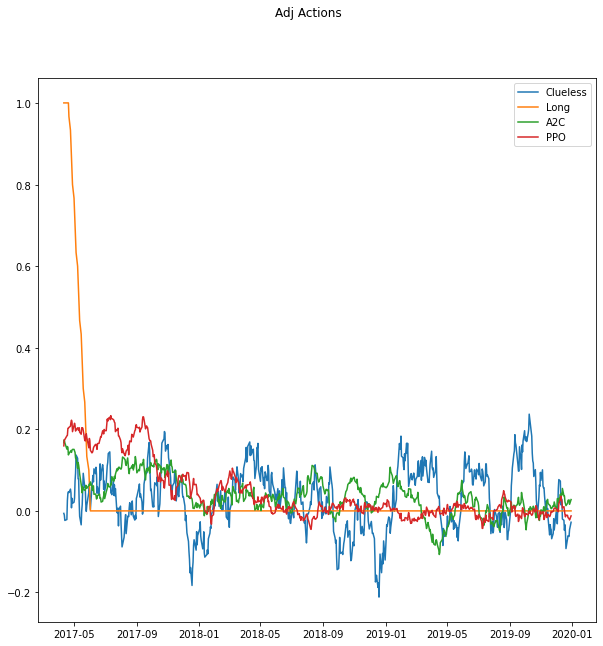

In [ ]:
player_rewards = []
player_sharpes = []
player_actions = []
player_adj_actions = []

player_rewards_dict = {}
player_sharpes_dict = {}
player_actions_dict = {}
player_adj_actions_dict = {}
episode_runs = 10
for i in range(episode_runs):
  players = ["Clueless", "Long", "A2C", "PPO"]
  player_models = {"Clueless": None, "Long": None, "A2C": best_model_a2c, "PPO": best_model_ppo}
  for player in players:

    rewards, sharpe_ratios, actions, adj_actions, dates, _ = trade(player, player_models[player], stock_list, 
                                                                      start_cash = start_cash, start_date = start_test, 
                                                                      end_date = end_test, trade_fee = trade_fee, 
        max_stock_order = max_order, scaling_factor = scaling, window = window, render = render, 
        rolling_action = 30, reward_scaling = scaled_reward, plot = False)
    
    adj_actions = [a for b in adj_actions for a in b]


    if i < 1:
      player_rewards_dict[player] = rewards
      player_sharpes_dict[player] = sharpe_ratios
      player_actions_dict[player] = actions
      player_adj_actions_dict[player] = adj_actions
    elif i >= episode_runs - 1:
      player_rewards_dict[player] = [(x+y)/episode_runs for x,y in zip(player_rewards_dict[player], rewards)]
      player_sharpes_dict[player] = [(x+y)/episode_runs for x,y in zip(player_sharpes_dict[player], sharpe_ratios)]
      player_actions_dict[player] = [(x+y)/episode_runs for x,y in zip(player_actions_dict[player], actions)]
      player_adj_actions_dict[player] = [(x+y)/episode_runs for x,y in zip(player_adj_actions_dict[player], adj_actions)]
    else:
      player_rewards_dict[player] = [x+y for x,y in zip(player_rewards_dict[player], rewards)]
      player_sharpes_dict[player] = [x+y for x,y in zip(player_sharpes_dict[player], sharpe_ratios)]
      player_actions_dict[player] = [x+y for x,y in zip(player_actions_dict[player], actions)]
      player_adj_actions_dict[player] = [x+y for x,y in zip(player_adj_actions_dict[player], adj_actions)]
      
for player in players:

  player_rewards.append(player_rewards_dict[player])
  player_sharpes.append( player_sharpes_dict[player])
  player_actions.append(player_actions_dict[player])
  player_adj_actions.append(player_adj_actions_dict[player])


plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window: window + len(rewards)], np.cumsum([player_rewards[k]]) / scaling / scaled_reward, 
           label = player)
plt.legend()
plt.title("Cumulative Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window: window + len(rewards)], 
           pd.DataFrame(np.array([player_rewards[k]]).reshape(len(player_rewards[k]),1)).rolling(30).mean() / scaling / scaled_reward, 
           label = player)
plt.legend()
plt.title("Rewards")
plt.show()
print("")

plt.figure(figsize = (10,10))
for k, player in enumerate(players):
  plt.plot(dates[window + 30 : len(rewards) + window : 30], player_sharpes[k], label = player)
plt.legend()
plt.title("Sharpe Ratios")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_actions[k])[i].rolling(30).mean(), 
              label = player)
  axes.legend()       
plt.suptitle("Actions")
plt.show()
print("")

fig, ax = plt.subplots(1, len(stock_list), figsize=(10, 10), sharex=True, sharey=True)
if len(stock_list) == 1:
  ax = [ax]
for i,axes in enumerate(ax):
  for k, player in enumerate(players):
    axes.plot(dates[window: window + len(rewards)], pd.DataFrame(player_adj_actions[k][window:])[i].rolling(30).mean(), label = player)
  axes.legend()       
plt.suptitle("Adj Actions")
plt.show()
print("")

In [ ]:
pd.DataFrame(player_sharpes_dict).to_csv("Single_stock_Sharpes_10_ep_test.csv")
pd.DataFrame(player_rewards_dict).to_csv("Single_stock_Rewards_10_ep_test.csv")

Observation:

In the testing environment, the story is quite different. In fact, whilst both agents are able to outperform the random actions, we can see when comparing the actions and ajusted actions plot that the A2C agent has better learnt than the PPO agent to deal with the situation when the environment rewards and agent no reward during training to deal with the situation of having no cash. It is likely that if the environment was in agent training mode, then the PPO agent would perform poorly in the testing environment. This likely occurs because the testing environment start with extreme growth and this could expose the agent to the flaw's in it's policy. This well presents the challenges in trying to apply the algorithm in a stock trading environment.

## Rendering with the PPO player

In [ ]:
stock_list = ["SPY"]
start_render = "2009-12-31"
end_render = "2020-01-01"
start_cash = 1e6
trade_fee = 1e-2
max_order = 100
scaling = 1e-4
window = 252 // 2
render = True #render environment
scaled_reward = 1
train = False #not in training mode

env = StockStreet(stock_list, init_date = start_render, end_date = end_render, init_capital = start_cash, buy_fee = trade_fee, 
                  sell_fee = trade_fee, max_stock_trade_qty = max_order, scale_factor = scaling, window_size = 252 // 2,
             dyn_render = render,full_render = True, reward_add_scale = scaled_reward, train_agent = train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


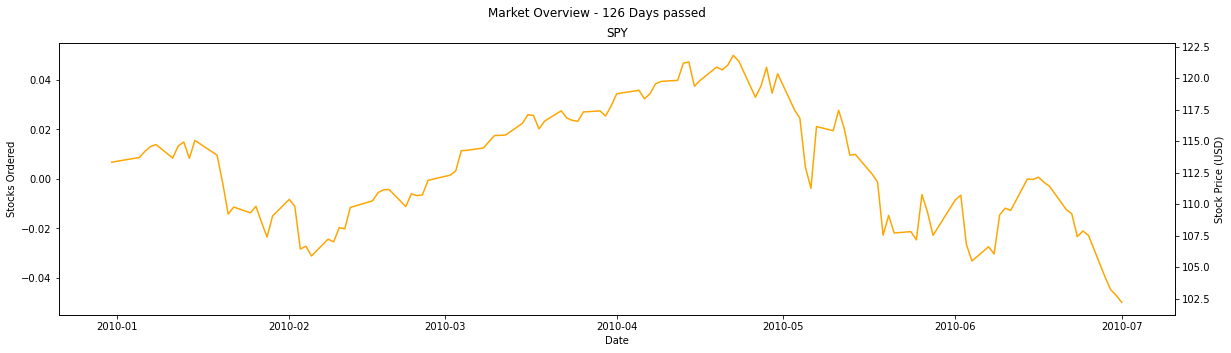

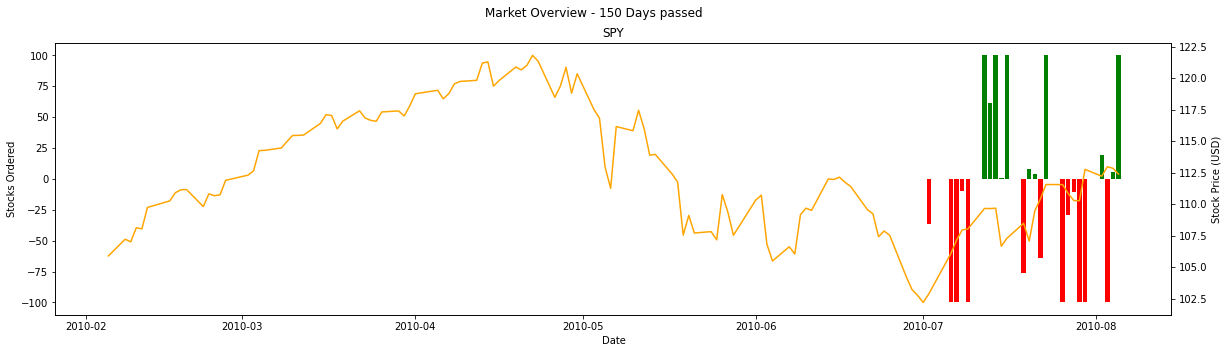

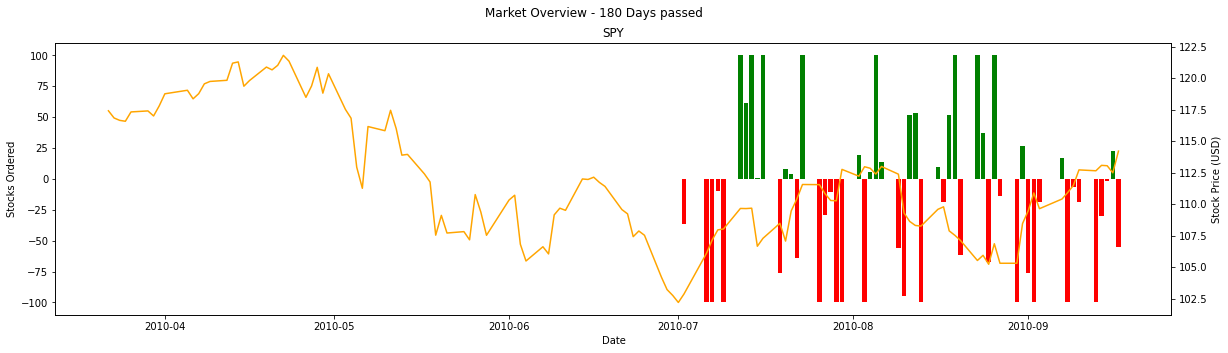

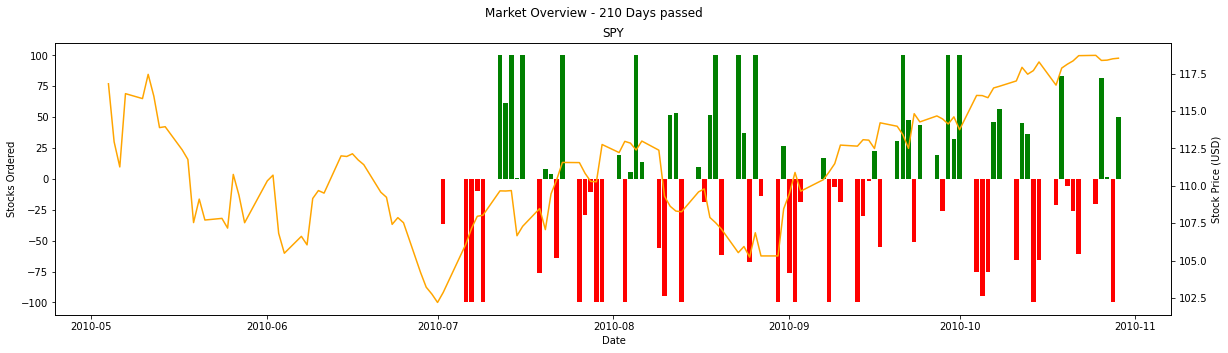

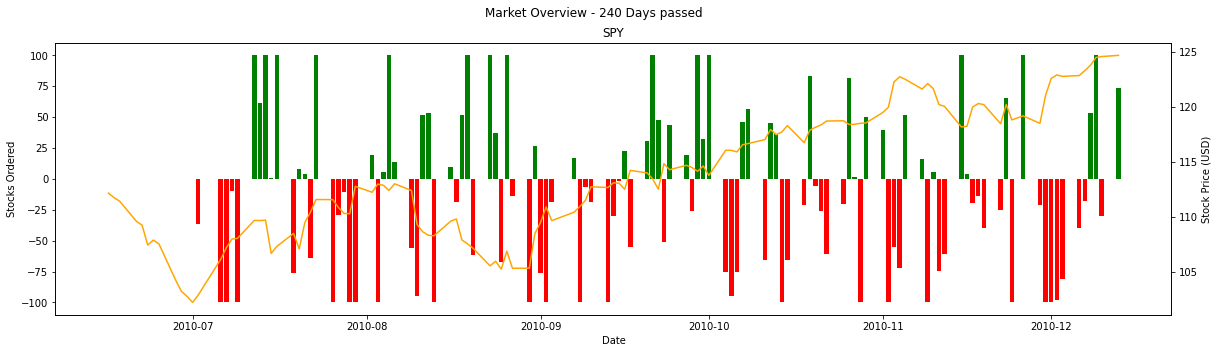

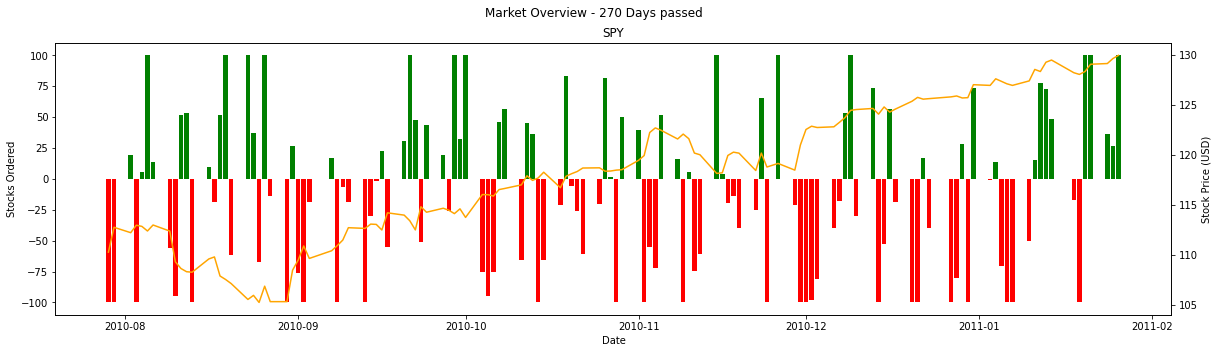

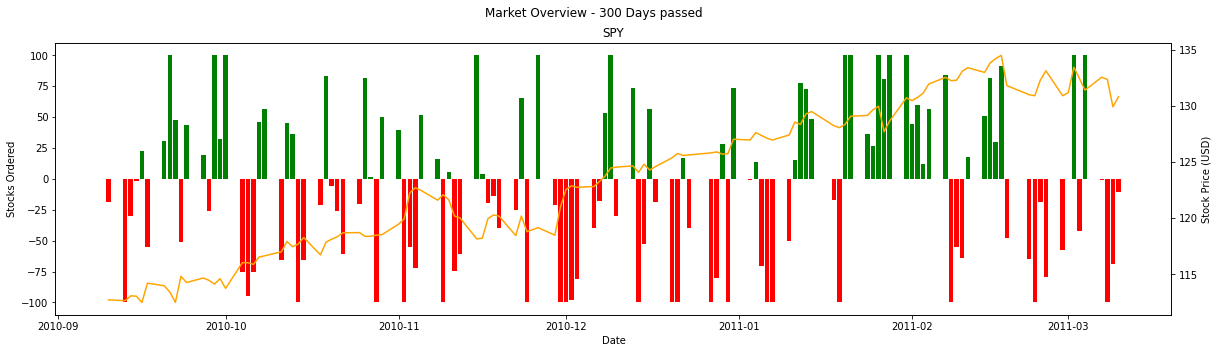

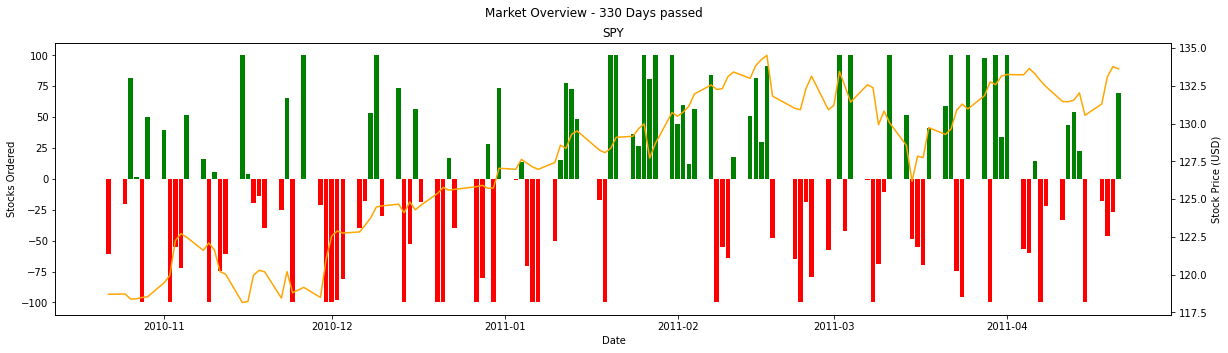

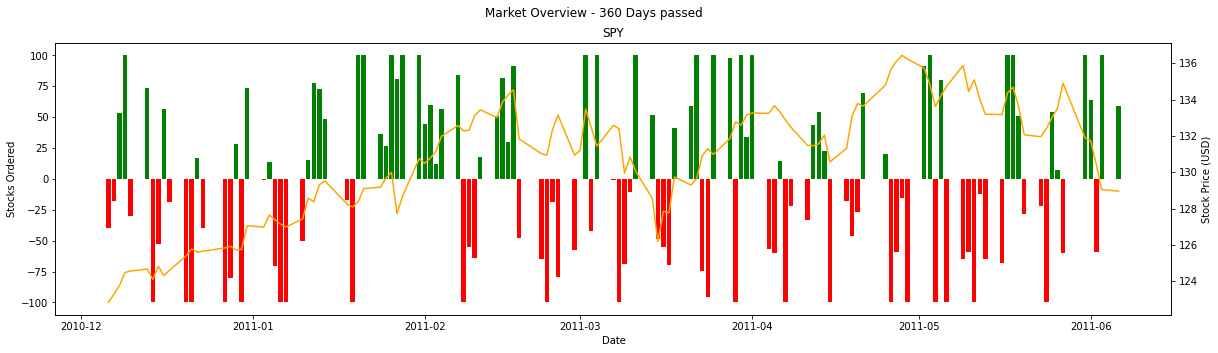

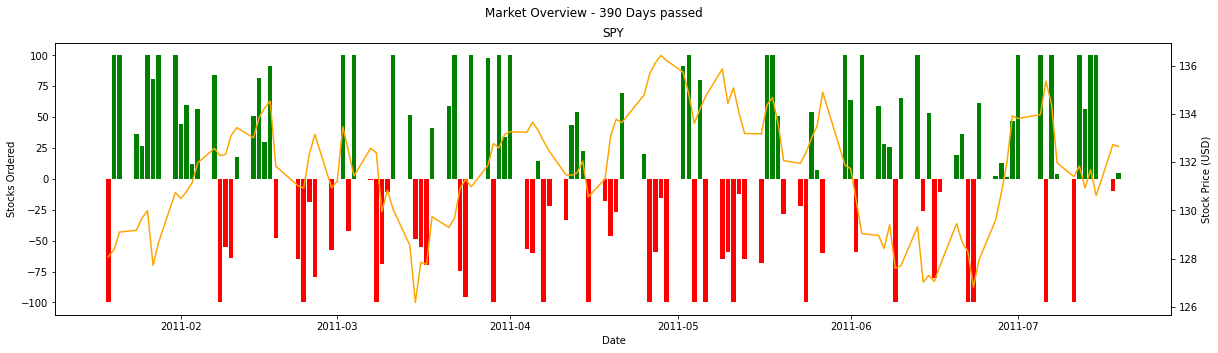

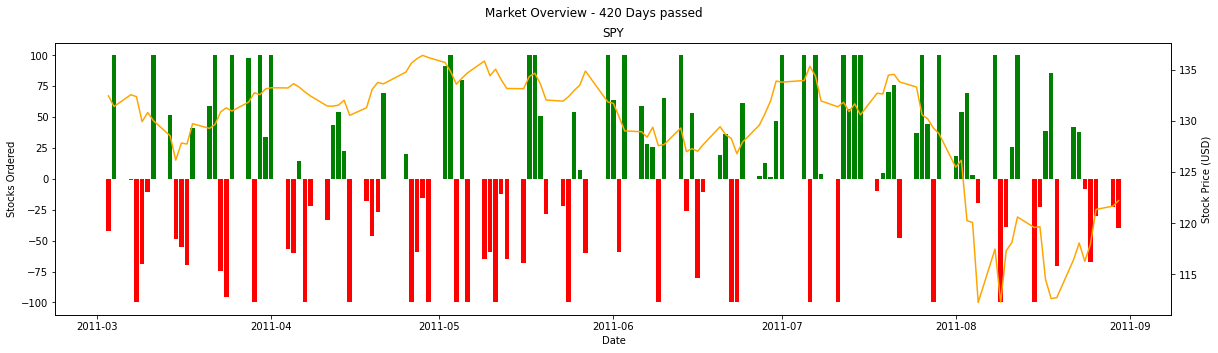

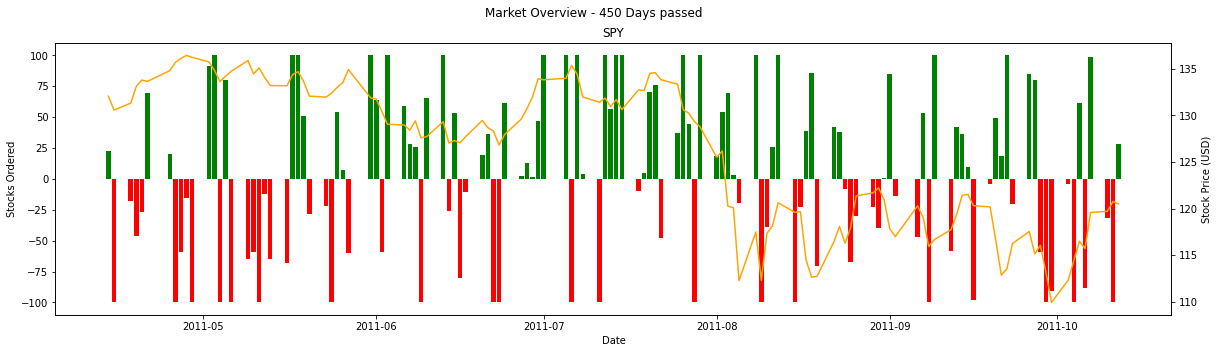

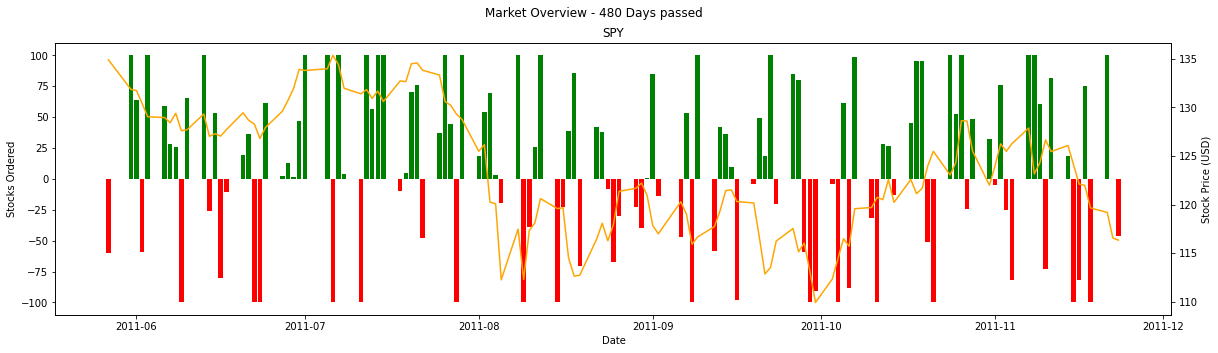

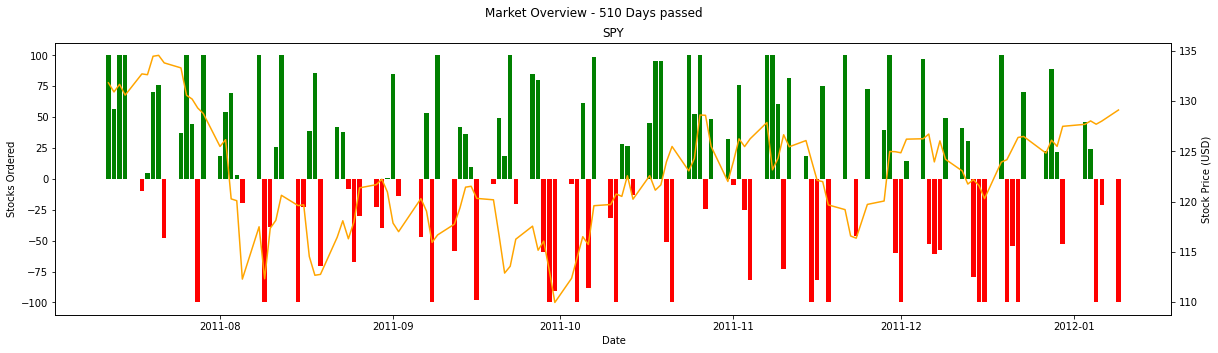

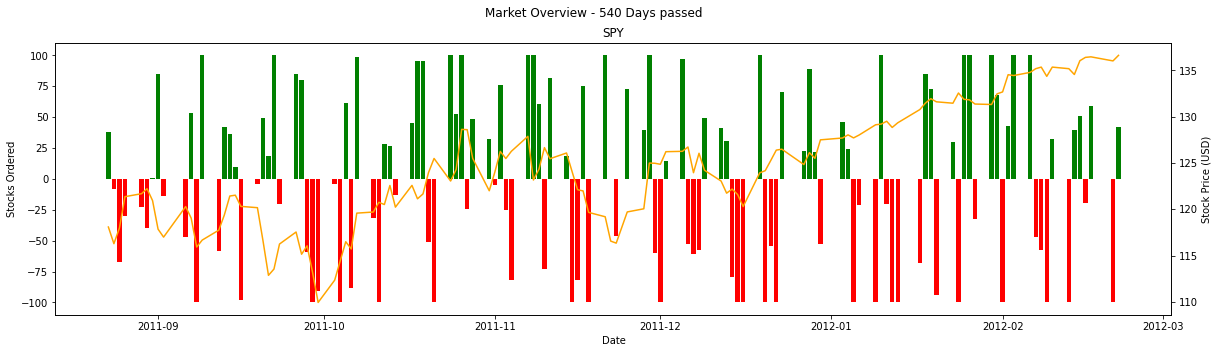

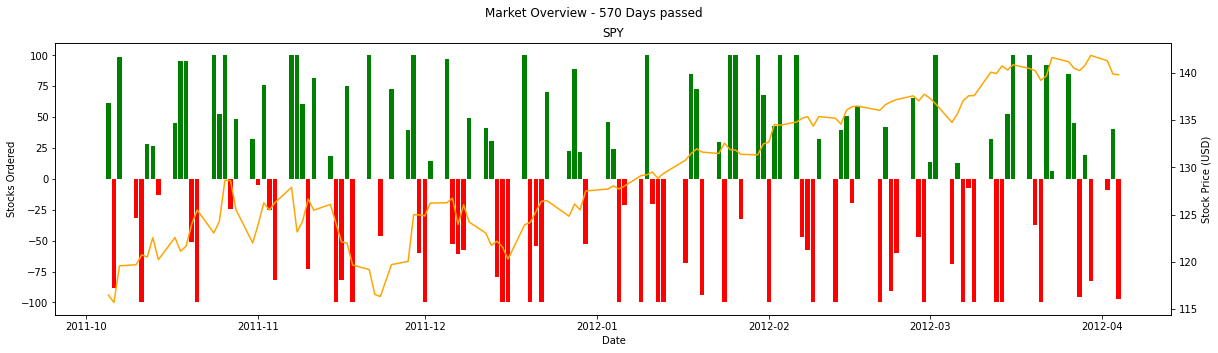

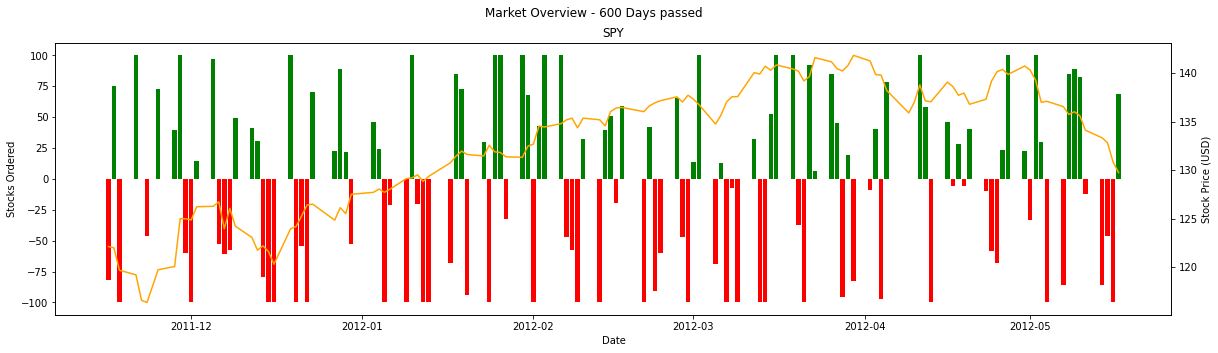

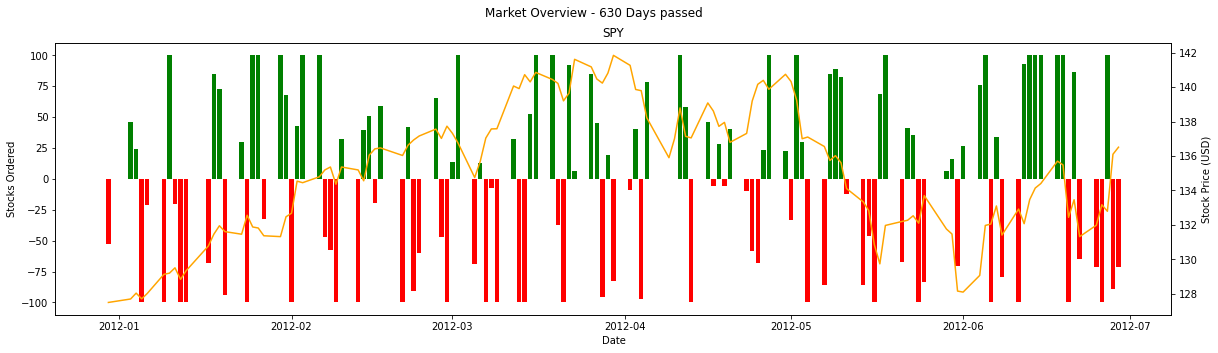

In [ ]:
obs = env.reset()
t = 0
testing_model = PPO("MlpPolicy", env)
testing_model.load("best_model_ppo_single.zip")
while t < 252 * 2:
  action, _ = testing_model.predict(obs)
  obs, reward, done, info = env.step(action) 
  t +=1 

# Multi-Stock Training

In the second testing phase, we attempt to train the agents in a multi-stock environment using the SPDR and MCD in the same period tests in the training set. The task is expected to generate extreme challenges compared to the Single Stock situation. Due to the severe increase in runtime using the multi stock environment (more observations, more calculations, more actions), no parameter sweeping was conducted in this environment. Furthermore, the provided observations may not be sufficient for this task. However, it is still interesting to attempt. A future work would be optimize the calculations made in the environment to drasticallt increase runtime and hence ability to properly tackle this problem.

In [ ]:
stock_list = ["SPY","MCD"]
start_train = "2009-12-31"
end_train = "2016-12-31"
start_test = "2016-08-28"
end_test = "2020-01-01"
start_cash = 1e6
trade_fee = 1e-2
max_order = 100
scaling = 1e-4
window = 252 // 2
render = False
scaled_reward = 1

env = StockStreet(stock_list, init_date = start_train, end_date = end_train, init_capital = start_cash, buy_fee = trade_fee, sell_fee = trade_fee,
               max_stock_trade_qty = max_order, set_seed = 72, log_transform = False, scale_factor = scaling, window_size = 252 // 2,
             dyn_render = False,full_render = True, reward_add_scale = scaled_reward, train_agent = True)